In [2]:
# delete all variables in the current scope
%reset -f

In [3]:
import json
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
# clear cuda cache
torch.cuda.empty_cache()


In [5]:
# hyperparameters
max_files = 200
path_to_files = '../embeddings/data/raw_data/'

min_len_playlist = 17
min_occurrences = 5

batch_size = 64 # how many independent sequences will we process in parallel?
block_size = min_len_playlist - 1
max_iters = 10000
eval_interval = 100
learning_rate = 4e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

n_embd = 640
n_head = 20
n_layer = 4

dropout = 0.05
# ------------

In [6]:

corpus = []
for i, file in tqdm(enumerate(os.listdir(path_to_files)[:max_files]), total=max_files):
    if i == max_files:
        break
    with open(path_to_files + file, 'r') as f:
        data = json.load(f)
        playlists = data['playlists']
        for playlist in playlists:
            cleaned_playlist = []
            for track in playlist['tracks']:
                cleaned_playlist.append(track['track_uri'])
            corpus.append(cleaned_playlist)

print(f'Number of playlists: {len(corpus)}')
print(f'Number of tracks: {sum([len(playlist) for playlist in corpus])}')


100%|██████████| 200/200 [00:55<00:00,  3.63it/s]

Number of playlists: 200000
Number of tracks: 13307825


In [7]:
print(device)

cuda


In [8]:
def filter_corpus(corpus, min_len_playlist, min_occurrences):
    song_counts = {}
    for playlist in corpus:
        for song in playlist:
            if song in song_counts:
                song_counts[song] += 1
            else:
                song_counts[song] = 1
    song_counts = {k: v for k, v in song_counts.items() if v >= min_occurrences}

    for i, playlist in enumerate(corpus):
        corpus[i] = [song for song in playlist if song in song_counts]
    
    filtered_corpus = []
    for playlist in corpus:
        if len(playlist) >= min_len_playlist:
            filtered_corpus.append(playlist)

    return filtered_corpus

total_len = sum([len(playlist) for playlist in corpus])
corpus = filter_corpus(corpus, min_len_playlist, min_occurrences)
print(f'Number of playlists: {len(corpus)}')

while sum([len(playlist) for playlist in corpus]) != total_len:
    total_len = sum([len(playlist) for playlist in corpus])
    corpus = filter_corpus(corpus, min_len_playlist, min_occurrences)
    print(f'Number of playlists: {len(corpus)}')

print()
print(corpus[0])

Number of playlists: 168168
Number of playlists: 167702
Number of playlists: 167646
Number of playlists: 167633
Number of playlists: 167629
Number of playlists: 167626
Number of playlists: 167626
Number of playlists: 167626

['spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak', 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv', 'spotify:track:1AWQoqb9bSvzTjaLralEkT', 'spotify:track:1lzr43nnXAijIGYnCT8M8H', 'spotify:track:0XUfyU2QviPAs6bxSpXYG4', 'spotify:track:68vgtRHr7iZHpzGpon6Jlo', 'spotify:track:3BxWKCI06eQ5Od8TY2JBeA', 'spotify:track:7H6ev70Weq6DdpZyyTmUXk', 'spotify:track:2PpruBYCo4H7WOBJ7Q2EwM', 'spotify:track:2gam98EZKrF9XuOkU13ApN', 'spotify:track:4Y45aqo9QMa57rDsAJv40A', 'spotify:track:1HwpWwa6bnqqRhK8agG4RS', 'spotify:track:20ORwCJusz4KS2PbTPVNKo', 'spotify:track:7k6IzwMGpxnRghE7YosnXT', 'spotify:track:1Bv0Yl01xBDZD4OQP93fyl', 'spotify:track:4omisSlTk6Dsq2iQD7MA07', 'spotify:track:7xYnUQigPoIDAMPVK79NEq', 'spotify:track:6d8A5sAx9TfdeseDvfWNHd', 'spotify:track

In [9]:
all_songs = []
for playlist in corpus:
    all_songs.extend(playlist)
all_songs = list(set(all_songs))
all_songs = sorted(all_songs)

print(len(all_songs))
print(all_songs[:3])
print(all_songs[-3:])

206091
['spotify:track:000VZqvXwT0YNqKk7iG2GS', 'spotify:track:000x2qE0ZI3hodeVrnJK8A', 'spotify:track:000xQL6tZNLJzIrtIgxqSl']
['spotify:track:7zzLt6Z9y7jMvXnEg00n58', 'spotify:track:7zzbfi8fvHe6hm342GcNYl', 'spotify:track:7zzmpRP0WkYge45l6LTQ8i']


In [10]:
stoi = {song:i for i, song in enumerate(all_songs)}
itos = {i:song for i, song in enumerate(all_songs)}

encode = lambda playlist: [stoi[song] for song in playlist]
decode = lambda array: [itos[song] for song in array]

vocab_size = len(all_songs)

print(encode(corpus[0]))

[13172, 166465, 14162, 31230, 47121, 14465, 162522, 84698, 192544, 64125, 71336, 120472, 34348, 53291, 199325, 31814, 127611, 205018, 175352, 128074, 53591, 24401, 30719, 34980, 190842, 39285, 41187, 168417, 161915, 81586, 143503, 165704, 111952, 86877, 103710, 74376, 162851, 46640, 201116, 27931, 72502, 113629, 152581, 70373, 157946, 40757, 103745, 99020, 148579, 182240, 42462, 165704]


In [11]:
data = [torch.tensor(encode(playlist)) for playlist in corpus]
for index in range(len(data)):
    data[index] = data[index].to(device)
print([len(playlist) for playlist in data][:5])

[52, 33, 60, 77, 17]


In [12]:
n = int(len(corpus) * 0.9)
print(n)

train_data = data[:n]
val_data = data[n:]

train_probs = np.array([len(playlist) - block_size for playlist in train_data])
train_probs = train_probs / train_probs.sum()

val_probs = np.array([len(playlist) - block_size for playlist in val_data])
val_probs = val_probs / val_probs.sum()


150863


In [13]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    probs = train_probs if split == 'train' else val_probs

    ix = np.random.choice(len(data), p=probs, size=batch_size)
    ixs = [np.random.randint(0, len(data[i]) - block_size) for i in ix]

    x = torch.stack([data[ix[i]][ixs[i]:ixs[i] + block_size] for i in range(batch_size)])
    y = torch.stack([data[ix[i]][ixs[i] + 1:ixs[i] + block_size + 1] for i in range(batch_size)])
    return x, y

In [14]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([64, 16])
tensor([[  9786,  26730,  74019,  ..., 116364,  67205, 172018],
        [ 19824, 160175, 175782,  ...,   7203,  68253,  34104],
        [112641,  21906,  61262,  ...,  72810, 149679,  49290],
        ...,
        [167433, 111980,  66634,  ...,  29643, 138150, 117130],
        [190170,  97698,  46761,  ...,  88701, 104556, 188503],
        [ 47339, 151242, 143119,  ..., 132513,  33009, 121496]],
       device='cuda:0')
targets:
torch.Size([64, 16])
tensor([[ 26730,  74019, 166159,  ...,  67205, 172018, 145162],
        [160175, 175782, 152788,  ...,  68253,  34104, 191773],
        [ 21906,  61262, 114840,  ..., 149679,  49290,  15106],
        ...,
        [111980,  66634, 102659,  ..., 138150, 117130, 138145],
        [ 97698,  46761,  69927,  ..., 104556, 188503,   4814],
        [151242, 143119,  94113,  ...,  33009, 121496, 151033]],
       device='cuda:0')
----
when input is [9786] the target: 26730
when input is [9786, 26730] the target: 74019
when in

In [15]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [16]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [17]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer



283.700491 M parameters


In [35]:

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_iters)

for iter in tqdm(range(max_iters + 2)):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    if (iter % 1000 == 0) and (iter > 0):
        torch.save(model.state_dict(), f"model_{iter}.pth")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    scheduler.step()

    


  0%|          | 0/10002 [00:00<?, ?it/s]

step 0: train loss 12.4038, val loss 12.4044


  1%|          | 100/10002 [06:50<9:01:46,  3.28s/it]

step 100: train loss 11.6052, val loss 11.6382


  2%|▏         | 200/10002 [14:37<8:50:41,  3.25s/it]  

step 200: train loss 10.9748, val loss 11.0017


  3%|▎         | 300/10002 [22:24<8:45:40,  3.25s/it]  

step 300: train loss 10.7388, val loss 10.7634


  4%|▍         | 400/10002 [30:11<8:40:09,  3.25s/it]  

step 400: train loss 10.6405, val loss 10.6572


  5%|▍         | 500/10002 [37:59<8:43:02,  3.30s/it]  

step 500: train loss 10.5756, val loss 10.5913


  6%|▌         | 600/10002 [45:59<8:35:00,  3.29s/it]  

step 600: train loss 10.5203, val loss 10.5539


  7%|▋         | 700/10002 [53:59<8:31:09,  3.30s/it]  

step 700: train loss 10.4527, val loss 10.5091


  8%|▊         | 800/10002 [1:02:00<8:27:06,  3.31s/it]

step 800: train loss 10.3732, val loss 10.4135


  9%|▉         | 900/10002 [1:10:00<8:22:44,  3.31s/it]  

step 900: train loss 10.2471, val loss 10.3297


 10%|▉         | 1000/10002 [1:17:59<8:12:13,  3.28s/it] 

step 1000: train loss 10.1398, val loss 10.2081


 11%|█         | 1100/10002 [1:26:03<8:04:25,  3.27s/it]  

step 1100: train loss 10.0922, val loss 10.1346


 12%|█▏        | 1200/10002 [1:33:50<7:56:31,  3.25s/it]  

step 1200: train loss 9.9997, val loss 10.1102


 13%|█▎        | 1300/10002 [1:41:37<7:51:37,  3.25s/it]  

step 1300: train loss 9.9402, val loss 10.0421


 14%|█▍        | 1400/10002 [1:49:26<7:49:45,  3.28s/it]  

step 1400: train loss 9.9091, val loss 10.0081


 15%|█▍        | 1500/10002 [1:57:13<7:41:22,  3.26s/it]  

step 1500: train loss 9.8621, val loss 9.9556


 16%|█▌        | 1600/10002 [2:05:00<7:37:29,  3.27s/it]  

step 1600: train loss 9.8076, val loss 9.8998


 17%|█▋        | 1700/10002 [2:12:46<7:27:52,  3.24s/it]  

step 1700: train loss 9.7422, val loss 9.8360


 18%|█▊        | 1800/10002 [2:20:32<7:25:51,  3.26s/it]  

step 1800: train loss 9.7269, val loss 9.8189


 19%|█▉        | 1900/10002 [2:28:19<7:17:07,  3.24s/it]  

step 1900: train loss 9.6903, val loss 9.7546


 20%|█▉        | 2000/10002 [2:36:07<7:18:04,  3.28s/it]  

step 2000: train loss 9.6327, val loss 9.7111


 21%|██        | 2100/10002 [2:44:10<7:14:17,  3.30s/it]  

step 2100: train loss 9.5666, val loss 9.6661


 22%|██▏       | 2200/10002 [2:52:12<7:07:55,  3.29s/it]  

step 2200: train loss 9.5390, val loss 9.6402


 23%|██▎       | 2300/10002 [3:00:12<7:02:52,  3.29s/it]  

step 2300: train loss 9.5016, val loss 9.6067


 24%|██▍       | 2400/10002 [3:08:13<6:58:57,  3.31s/it]  

step 2400: train loss 9.4590, val loss 9.5634


 25%|██▍       | 2500/10002 [3:16:14<6:50:36,  3.28s/it]  

step 2500: train loss 9.3952, val loss 9.5383


 26%|██▌       | 2600/10002 [3:24:14<6:51:01,  3.33s/it]  

step 2600: train loss 9.3836, val loss 9.5173


 27%|██▋       | 2700/10002 [3:32:14<6:40:56,  3.29s/it]  

step 2700: train loss 9.3706, val loss 9.4594


 28%|██▊       | 2800/10002 [3:40:14<6:35:40,  3.30s/it] 

step 2800: train loss 9.3263, val loss 9.4381


 29%|██▉       | 2900/10002 [3:48:25<6:30:07,  3.30s/it] 

step 2900: train loss 9.2931, val loss 9.4085


 30%|██▉       | 3000/10002 [3:56:25<6:20:18,  3.26s/it] 

step 3000: train loss 9.2705, val loss 9.3785


 31%|███       | 3100/10002 [4:04:28<6:17:06,  3.28s/it] 

step 3100: train loss 9.2200, val loss 9.3478


 32%|███▏      | 3200/10002 [4:12:28<6:11:05,  3.27s/it] 

step 3200: train loss 9.2273, val loss 9.3530


 33%|███▎      | 3300/10002 [4:20:28<6:07:18,  3.29s/it] 

step 3300: train loss 9.1739, val loss 9.2881


 34%|███▍      | 3400/10002 [4:28:28<6:01:52,  3.29s/it] 

step 3400: train loss 9.1725, val loss 9.2731


 35%|███▍      | 3500/10002 [4:36:29<5:57:40,  3.30s/it] 

step 3500: train loss 9.1302, val loss 9.2625


 36%|███▌      | 3600/10002 [4:44:29<5:52:09,  3.30s/it] 

step 3600: train loss 9.1241, val loss 9.2698


 37%|███▋      | 3700/10002 [4:52:31<5:46:08,  3.30s/it] 

step 3700: train loss 9.1049, val loss 9.1797


 38%|███▊      | 3800/10002 [5:00:30<5:42:09,  3.31s/it] 

step 3800: train loss 9.0759, val loss 9.2067


 39%|███▉      | 3900/10002 [5:08:30<5:34:04,  3.28s/it] 

step 3900: train loss 9.0265, val loss 9.1780


 40%|███▉      | 4000/10002 [5:16:30<5:29:54,  3.30s/it] 

step 4000: train loss 9.0012, val loss 9.1210


 41%|████      | 4100/10002 [5:24:33<5:24:38,  3.30s/it] 

step 4100: train loss 9.0341, val loss 9.1587


 42%|████▏     | 4200/10002 [5:32:33<5:18:14,  3.29s/it] 

step 4200: train loss 8.9892, val loss 9.1436


 43%|████▎     | 4300/10002 [5:40:34<5:11:55,  3.28s/it] 

step 4300: train loss 8.9675, val loss 9.1033


 44%|████▍     | 4400/10002 [5:48:34<5:08:59,  3.31s/it] 

step 4400: train loss 8.9553, val loss 9.0786


 45%|████▍     | 4500/10002 [5:56:35<5:01:17,  3.29s/it] 

step 4500: train loss 8.9232, val loss 9.0819


 46%|████▌     | 4600/10002 [6:04:36<4:55:00,  3.28s/it] 

step 4600: train loss 8.9291, val loss 9.0713


 47%|████▋     | 4700/10002 [6:12:36<4:51:59,  3.30s/it] 

step 4700: train loss 8.8952, val loss 9.0229


 48%|████▊     | 4800/10002 [6:20:37<4:46:58,  3.31s/it] 

step 4800: train loss 8.8546, val loss 9.0344


 49%|████▉     | 4900/10002 [6:28:38<4:43:05,  3.33s/it] 

step 4900: train loss 8.8646, val loss 8.9839


 50%|████▉     | 5000/10002 [6:36:38<4:34:45,  3.30s/it] 

step 5000: train loss 8.8237, val loss 9.0121


 51%|█████     | 5100/10002 [6:44:41<4:30:04,  3.31s/it] 

step 5100: train loss 8.8137, val loss 8.9554


 52%|█████▏    | 5200/10002 [6:52:42<4:25:02,  3.31s/it] 

step 5200: train loss 8.8275, val loss 8.9687


 53%|█████▎    | 5300/10002 [7:00:42<4:17:29,  3.29s/it] 

step 5300: train loss 8.8118, val loss 8.9451


 54%|█████▍    | 5400/10002 [7:08:43<4:13:04,  3.30s/it] 

step 5400: train loss 8.7688, val loss 8.9499


 55%|█████▍    | 5500/10002 [7:16:43<4:07:13,  3.29s/it] 

step 5500: train loss 8.7640, val loss 8.8946


 56%|█████▌    | 5600/10002 [7:24:44<4:00:05,  3.27s/it] 

step 5600: train loss 8.7204, val loss 8.9017


 57%|█████▋    | 5700/10002 [7:32:45<3:56:37,  3.30s/it] 

step 5700: train loss 8.7169, val loss 8.8952


 58%|█████▊    | 5800/10002 [7:40:45<3:50:30,  3.29s/it] 

step 5800: train loss 8.7133, val loss 8.8707


 59%|█████▉    | 5900/10002 [7:48:46<3:45:31,  3.30s/it] 

step 5900: train loss 8.7047, val loss 8.8488


 60%|█████▉    | 6000/10002 [7:56:45<3:40:42,  3.31s/it] 

step 6000: train loss 8.6807, val loss 8.8315


 61%|██████    | 6100/10002 [8:04:48<3:33:31,  3.28s/it] 

step 6100: train loss 8.6701, val loss 8.8227


 62%|██████▏   | 6200/10002 [8:12:48<3:27:30,  3.27s/it] 

step 6200: train loss 8.6508, val loss 8.8069


 63%|██████▎   | 6300/10002 [8:20:49<3:23:40,  3.30s/it] 

step 6300: train loss 8.6181, val loss 8.7954


 64%|██████▍   | 6400/10002 [8:28:49<3:18:14,  3.30s/it] 

step 6400: train loss 8.6148, val loss 8.7719


 65%|██████▍   | 6500/10002 [8:36:50<3:13:28,  3.31s/it] 

step 6500: train loss 8.5883, val loss 8.7709


 66%|██████▌   | 6600/10002 [8:44:51<3:06:42,  3.29s/it] 

step 6600: train loss 8.5786, val loss 8.7409


 67%|██████▋   | 6700/10002 [8:52:51<3:01:00,  3.29s/it] 

step 6700: train loss 8.5611, val loss 8.7205


 68%|██████▊   | 6800/10002 [9:00:52<2:56:02,  3.30s/it] 

step 6800: train loss 8.5615, val loss 8.7130


 69%|██████▉   | 6900/10002 [9:08:53<2:51:05,  3.31s/it] 

step 6900: train loss 8.5318, val loss 8.6980


 70%|██████▉   | 7000/10002 [9:16:53<2:46:14,  3.32s/it] 

step 7000: train loss 8.5172, val loss 8.6947


 71%|███████   | 7100/10002 [9:24:56<2:40:03,  3.31s/it] 

step 7100: train loss 8.5096, val loss 8.6732


 72%|███████▏  | 7200/10002 [9:32:56<2:34:36,  3.31s/it] 

step 7200: train loss 8.5000, val loss 8.6758


 73%|███████▎  | 7300/10002 [9:40:57<2:27:44,  3.28s/it] 

step 7300: train loss 8.5243, val loss 8.6766


 74%|███████▍  | 7400/10002 [9:49:00<2:23:06,  3.30s/it] 

step 7400: train loss 8.4945, val loss 8.6589


 75%|███████▍  | 7500/10002 [9:57:00<2:16:41,  3.28s/it] 

step 7500: train loss 8.4650, val loss 8.6569


 76%|███████▌  | 7600/10002 [10:05:00<2:10:43,  3.27s/it]

step 7600: train loss 8.4563, val loss 8.6571


 77%|███████▋  | 7700/10002 [10:13:01<2:06:37,  3.30s/it] 

step 7700: train loss 8.4847, val loss 8.6545


 78%|███████▊  | 7800/10002 [10:21:01<2:01:04,  3.30s/it] 

step 7800: train loss 8.4264, val loss 8.6442


 79%|███████▉  | 7900/10002 [10:29:04<1:55:57,  3.31s/it] 

step 7900: train loss 8.4539, val loss 8.6261


 80%|███████▉  | 8000/10002 [10:37:04<1:49:41,  3.29s/it] 

step 8000: train loss 8.4264, val loss 8.5978


 81%|████████  | 8100/10002 [10:45:06<1:43:42,  3.27s/it] 

step 8100: train loss 8.4235, val loss 8.5834


 82%|████████▏ | 8200/10002 [10:53:07<1:39:22,  3.31s/it] 

step 8200: train loss 8.4163, val loss 8.5839


 83%|████████▎ | 8300/10002 [11:01:07<1:33:04,  3.28s/it] 

step 8300: train loss 8.4076, val loss 8.5767


 84%|████████▍ | 8400/10002 [11:09:08<1:28:19,  3.31s/it] 

step 8400: train loss 8.3626, val loss 8.5611


 85%|████████▍ | 8500/10002 [11:17:09<1:22:16,  3.29s/it] 

step 8500: train loss 8.3840, val loss 8.6015


 86%|████████▌ | 8600/10002 [11:25:10<1:17:26,  3.31s/it] 

step 8600: train loss 8.3916, val loss 8.5856


 87%|████████▋ | 8700/10002 [11:33:08<1:10:31,  3.25s/it] 

step 8700: train loss 8.3661, val loss 8.5698


 88%|████████▊ | 8800/10002 [11:40:55<1:05:23,  3.26s/it] 

step 8800: train loss 8.3785, val loss 8.5679


 89%|████████▉ | 8900/10002 [11:48:41<1:00:01,  3.27s/it] 

step 8900: train loss 8.3706, val loss 8.5773


 90%|████████▉ | 9000/10002 [11:56:28<54:37,  3.27s/it]   

step 9000: train loss 8.3908, val loss 8.5529


 91%|█████████ | 9100/10002 [12:04:17<49:20,  3.28s/it]   

step 9100: train loss 8.3626, val loss 8.5171


 92%|█████████▏| 9200/10002 [12:12:03<43:36,  3.26s/it]   

step 9200: train loss 8.3661, val loss 8.5493


 93%|█████████▎| 9300/10002 [12:19:50<38:19,  3.28s/it]   

step 9300: train loss 8.3675, val loss 8.5602


 94%|█████████▍| 9400/10002 [12:27:36<32:49,  3.27s/it]  

step 9400: train loss 8.3879, val loss 8.5428


 95%|█████████▍| 9500/10002 [12:35:23<27:27,  3.28s/it]  

step 9500: train loss 8.3821, val loss 8.5504


 96%|█████████▌| 9600/10002 [12:43:12<22:08,  3.31s/it]  

step 9600: train loss 8.3517, val loss 8.5289


 97%|█████████▋| 9700/10002 [12:51:12<16:33,  3.29s/it]  

step 9700: train loss 8.3636, val loss 8.5693


 98%|█████████▊| 9800/10002 [12:59:13<11:04,  3.29s/it]  

step 9800: train loss 8.3643, val loss 8.5738


 99%|█████████▉| 9900/10002 [13:07:13<05:37,  3.30s/it]  

step 9900: train loss 8.3665, val loss 8.5484


100%|█████████▉| 9999/10002 [13:15:10<00:09,  3.31s/it]  

step 9999: train loss 8.3756, val loss 8.5612


100%|█████████▉| 10000/10002 [13:17:44<01:36, 48.47s/it]

step 10000: train loss 8.3954, val loss 8.5737


100%|██████████| 10002/10002 [13:20:24<00:00,  4.80s/it]


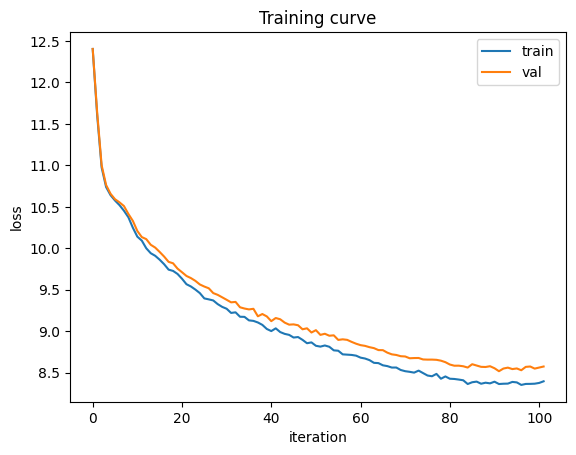

In [18]:
training_txt = '''0%|          | 0/10002 [00:00<?, ?it/s]
step 0: train loss 12.4038, val loss 12.4044
  1%|          | 100/10002 [06:50<9:01:46,  3.28s/it]
step 100: train loss 11.6052, val loss 11.6382
  2%|▏         | 200/10002 [14:37<8:50:41,  3.25s/it]  
step 200: train loss 10.9748, val loss 11.0017
  3%|▎         | 300/10002 [22:24<8:45:40,  3.25s/it]  
step 300: train loss 10.7388, val loss 10.7634
  4%|▍         | 400/10002 [30:11<8:40:09,  3.25s/it]  
step 400: train loss 10.6405, val loss 10.6572
  5%|▍         | 500/10002 [37:59<8:43:02,  3.30s/it]  
step 500: train loss 10.5756, val loss 10.5913
  6%|▌         | 600/10002 [45:59<8:35:00,  3.29s/it]  
step 600: train loss 10.5203, val loss 10.5539
  7%|▋         | 700/10002 [53:59<8:31:09,  3.30s/it]  
step 700: train loss 10.4527, val loss 10.5091
  8%|▊         | 800/10002 [1:02:00<8:27:06,  3.31s/it]
step 800: train loss 10.3732, val loss 10.4135
  9%|▉         | 900/10002 [1:10:00<8:22:44,  3.31s/it]  
step 900: train loss 10.2471, val loss 10.3297
 10%|▉         | 1000/10002 [1:17:59<8:12:13,  3.28s/it] 
step 1000: train loss 10.1398, val loss 10.2081
 11%|█         | 1100/10002 [1:26:03<8:04:25,  3.27s/it]  
step 1100: train loss 10.0922, val loss 10.1346
 12%|█▏        | 1200/10002 [1:33:50<7:56:31,  3.25s/it]  
step 1200: train loss 9.9997, val loss 10.1102
 13%|█▎        | 1300/10002 [1:41:37<7:51:37,  3.25s/it]  
step 1300: train loss 9.9402, val loss 10.0421
 14%|█▍        | 1400/10002 [1:49:26<7:49:45,  3.28s/it]  
step 1400: train loss 9.9091, val loss 10.0081
 15%|█▍        | 1500/10002 [1:57:13<7:41:22,  3.26s/it]  
step 1500: train loss 9.8621, val loss 9.9556
 16%|█▌        | 1600/10002 [2:05:00<7:37:29,  3.27s/it]  
step 1600: train loss 9.8076, val loss 9.8998
 17%|█▋        | 1700/10002 [2:12:46<7:27:52,  3.24s/it]  
step 1700: train loss 9.7422, val loss 9.8360
 18%|█▊        | 1800/10002 [2:20:32<7:25:51,  3.26s/it]  
step 1800: train loss 9.7269, val loss 9.8189
 19%|█▉        | 1900/10002 [2:28:19<7:17:07,  3.24s/it]  
step 1900: train loss 9.6903, val loss 9.7546
 20%|█▉        | 2000/10002 [2:36:07<7:18:04,  3.28s/it]  
step 2000: train loss 9.6327, val loss 9.7111
 21%|██        | 2100/10002 [2:44:10<7:14:17,  3.30s/it]  
step 2100: train loss 9.5666, val loss 9.6661
 22%|██▏       | 2200/10002 [2:52:12<7:07:55,  3.29s/it]  
step 2200: train loss 9.5390, val loss 9.6402
 23%|██▎       | 2300/10002 [3:00:12<7:02:52,  3.29s/it]  
step 2300: train loss 9.5016, val loss 9.6067
 24%|██▍       | 2400/10002 [3:08:13<6:58:57,  3.31s/it]  
step 2400: train loss 9.4590, val loss 9.5634
 25%|██▍       | 2500/10002 [3:16:14<6:50:36,  3.28s/it]  
step 2500: train loss 9.3952, val loss 9.5383
 26%|██▌       | 2600/10002 [3:24:14<6:51:01,  3.33s/it]  
step 2600: train loss 9.3836, val loss 9.5173
 27%|██▋       | 2700/10002 [3:32:14<6:40:56,  3.29s/it]  
step 2700: train loss 9.3706, val loss 9.4594
 28%|██▊       | 2800/10002 [3:40:14<6:35:40,  3.30s/it] 
step 2800: train loss 9.3263, val loss 9.4381
 29%|██▉       | 2900/10002 [3:48:25<6:30:07,  3.30s/it] 
step 2900: train loss 9.2931, val loss 9.4085
 30%|██▉       | 3000/10002 [3:56:25<6:20:18,  3.26s/it] 
step 3000: train loss 9.2705, val loss 9.3785
 31%|███       | 3100/10002 [4:04:28<6:17:06,  3.28s/it] 
step 3100: train loss 9.2200, val loss 9.3478
 32%|███▏      | 3200/10002 [4:12:28<6:11:05,  3.27s/it] 
step 3200: train loss 9.2273, val loss 9.3530
 33%|███▎      | 3300/10002 [4:20:28<6:07:18,  3.29s/it] 
step 3300: train loss 9.1739, val loss 9.2881
 34%|███▍      | 3400/10002 [4:28:28<6:01:52,  3.29s/it] 
step 3400: train loss 9.1725, val loss 9.2731
 35%|███▍      | 3500/10002 [4:36:29<5:57:40,  3.30s/it] 
step 3500: train loss 9.1302, val loss 9.2625
 36%|███▌      | 3600/10002 [4:44:29<5:52:09,  3.30s/it] 
step 3600: train loss 9.1241, val loss 9.2698
 37%|███▋      | 3700/10002 [4:52:31<5:46:08,  3.30s/it] 
step 3700: train loss 9.1049, val loss 9.1797
 38%|███▊      | 3800/10002 [5:00:30<5:42:09,  3.31s/it] 
step 3800: train loss 9.0759, val loss 9.2067
 39%|███▉      | 3900/10002 [5:08:30<5:34:04,  3.28s/it] 
step 3900: train loss 9.0265, val loss 9.1780
 40%|███▉      | 4000/10002 [5:16:30<5:29:54,  3.30s/it] 
step 4000: train loss 9.0012, val loss 9.1210
 41%|████      | 4100/10002 [5:24:33<5:24:38,  3.30s/it] 
step 4100: train loss 9.0341, val loss 9.1587
 42%|████▏     | 4200/10002 [5:32:33<5:18:14,  3.29s/it] 
step 4200: train loss 8.9892, val loss 9.1436
 43%|████▎     | 4300/10002 [5:40:34<5:11:55,  3.28s/it] 
step 4300: train loss 8.9675, val loss 9.1033
 44%|████▍     | 4400/10002 [5:48:34<5:08:59,  3.31s/it] 
step 4400: train loss 8.9553, val loss 9.0786
 45%|████▍     | 4500/10002 [5:56:35<5:01:17,  3.29s/it] 
step 4500: train loss 8.9232, val loss 9.0819
 46%|████▌     | 4600/10002 [6:04:36<4:55:00,  3.28s/it] 
step 4600: train loss 8.9291, val loss 9.0713
 47%|████▋     | 4700/10002 [6:12:36<4:51:59,  3.30s/it] 
step 4700: train loss 8.8952, val loss 9.0229
 48%|████▊     | 4800/10002 [6:20:37<4:46:58,  3.31s/it] 
step 4800: train loss 8.8546, val loss 9.0344
 49%|████▉     | 4900/10002 [6:28:38<4:43:05,  3.33s/it] 
step 4900: train loss 8.8646, val loss 8.9839
 50%|████▉     | 5000/10002 [6:36:38<4:34:45,  3.30s/it] 
step 5000: train loss 8.8237, val loss 9.0121
 51%|█████     | 5100/10002 [6:44:41<4:30:04,  3.31s/it] 
step 5100: train loss 8.8137, val loss 8.9554
 52%|█████▏    | 5200/10002 [6:52:42<4:25:02,  3.31s/it] 
step 5200: train loss 8.8275, val loss 8.9687
 53%|█████▎    | 5300/10002 [7:00:42<4:17:29,  3.29s/it] 
step 5300: train loss 8.8118, val loss 8.9451
 54%|█████▍    | 5400/10002 [7:08:43<4:13:04,  3.30s/it] 
step 5400: train loss 8.7688, val loss 8.9499
 55%|█████▍    | 5500/10002 [7:16:43<4:07:13,  3.29s/it] 
step 5500: train loss 8.7640, val loss 8.8946
 56%|█████▌    | 5600/10002 [7:24:44<4:00:05,  3.27s/it] 
step 5600: train loss 8.7204, val loss 8.9017
 57%|█████▋    | 5700/10002 [7:32:45<3:56:37,  3.30s/it] 
step 5700: train loss 8.7169, val loss 8.8952
 58%|█████▊    | 5800/10002 [7:40:45<3:50:30,  3.29s/it] 
step 5800: train loss 8.7133, val loss 8.8707
 59%|█████▉    | 5900/10002 [7:48:46<3:45:31,  3.30s/it] 
step 5900: train loss 8.7047, val loss 8.8488
 60%|█████▉    | 6000/10002 [7:56:45<3:40:42,  3.31s/it] 
step 6000: train loss 8.6807, val loss 8.8315
 61%|██████    | 6100/10002 [8:04:48<3:33:31,  3.28s/it] 
step 6100: train loss 8.6701, val loss 8.8227
 62%|██████▏   | 6200/10002 [8:12:48<3:27:30,  3.27s/it] 
step 6200: train loss 8.6508, val loss 8.8069
 63%|██████▎   | 6300/10002 [8:20:49<3:23:40,  3.30s/it] 
step 6300: train loss 8.6181, val loss 8.7954
 64%|██████▍   | 6400/10002 [8:28:49<3:18:14,  3.30s/it] 
step 6400: train loss 8.6148, val loss 8.7719
 65%|██████▍   | 6500/10002 [8:36:50<3:13:28,  3.31s/it] 
step 6500: train loss 8.5883, val loss 8.7709
 66%|██████▌   | 6600/10002 [8:44:51<3:06:42,  3.29s/it] 
step 6600: train loss 8.5786, val loss 8.7409
 67%|██████▋   | 6700/10002 [8:52:51<3:01:00,  3.29s/it] 
step 6700: train loss 8.5611, val loss 8.7205
 68%|██████▊   | 6800/10002 [9:00:52<2:56:02,  3.30s/it] 
step 6800: train loss 8.5615, val loss 8.7130
 69%|██████▉   | 6900/10002 [9:08:53<2:51:05,  3.31s/it] 
step 6900: train loss 8.5318, val loss 8.6980
 70%|██████▉   | 7000/10002 [9:16:53<2:46:14,  3.32s/it] 
step 7000: train loss 8.5172, val loss 8.6947
 71%|███████   | 7100/10002 [9:24:56<2:40:03,  3.31s/it] 
step 7100: train loss 8.5096, val loss 8.6732
 72%|███████▏  | 7200/10002 [9:32:56<2:34:36,  3.31s/it] 
step 7200: train loss 8.5000, val loss 8.6758
 73%|███████▎  | 7300/10002 [9:40:57<2:27:44,  3.28s/it] 
step 7300: train loss 8.5243, val loss 8.6766
 74%|███████▍  | 7400/10002 [9:49:00<2:23:06,  3.30s/it] 
step 7400: train loss 8.4945, val loss 8.6589
 75%|███████▍  | 7500/10002 [9:57:00<2:16:41,  3.28s/it] 
step 7500: train loss 8.4650, val loss 8.6569
 76%|███████▌  | 7600/10002 [10:05:00<2:10:43,  3.27s/it]
step 7600: train loss 8.4563, val loss 8.6571
 77%|███████▋  | 7700/10002 [10:13:01<2:06:37,  3.30s/it] 
step 7700: train loss 8.4847, val loss 8.6545
 78%|███████▊  | 7800/10002 [10:21:01<2:01:04,  3.30s/it] 
step 7800: train loss 8.4264, val loss 8.6442
 79%|███████▉  | 7900/10002 [10:29:04<1:55:57,  3.31s/it] 
step 7900: train loss 8.4539, val loss 8.6261
 80%|███████▉  | 8000/10002 [10:37:04<1:49:41,  3.29s/it] 
step 8000: train loss 8.4264, val loss 8.5978
 81%|████████  | 8100/10002 [10:45:06<1:43:42,  3.27s/it] 
step 8100: train loss 8.4235, val loss 8.5834
 82%|████████▏ | 8200/10002 [10:53:07<1:39:22,  3.31s/it] 
step 8200: train loss 8.4163, val loss 8.5839
 83%|████████▎ | 8300/10002 [11:01:07<1:33:04,  3.28s/it] 
step 8300: train loss 8.4076, val loss 8.5767
 84%|████████▍ | 8400/10002 [11:09:08<1:28:19,  3.31s/it] 
step 8400: train loss 8.3626, val loss 8.5611
 85%|████████▍ | 8500/10002 [11:17:09<1:22:16,  3.29s/it] 
step 8500: train loss 8.3840, val loss 8.6015
 86%|████████▌ | 8600/10002 [11:25:10<1:17:26,  3.31s/it] 
step 8600: train loss 8.3916, val loss 8.5856
 87%|████████▋ | 8700/10002 [11:33:08<1:10:31,  3.25s/it] 
step 8700: train loss 8.3661, val loss 8.5698
 88%|████████▊ | 8800/10002 [11:40:55<1:05:23,  3.26s/it] 
step 8800: train loss 8.3785, val loss 8.5679
 89%|████████▉ | 8900/10002 [11:48:41<1:00:01,  3.27s/it] 
step 8900: train loss 8.3706, val loss 8.5773
 90%|████████▉ | 9000/10002 [11:56:28<54:37,  3.27s/it]   
step 9000: train loss 8.3908, val loss 8.5529
 91%|█████████ | 9100/10002 [12:04:17<49:20,  3.28s/it]   
step 9100: train loss 8.3626, val loss 8.5171
 92%|█████████▏| 9200/10002 [12:12:03<43:36,  3.26s/it]   
step 9200: train loss 8.3661, val loss 8.5493
 93%|█████████▎| 9300/10002 [12:19:50<38:19,  3.28s/it]   
step 9300: train loss 8.3675, val loss 8.5602
 94%|█████████▍| 9400/10002 [12:27:36<32:49,  3.27s/it]  
step 9400: train loss 8.3879, val loss 8.5428
 95%|█████████▍| 9500/10002 [12:35:23<27:27,  3.28s/it]  
step 9500: train loss 8.3821, val loss 8.5504
 96%|█████████▌| 9600/10002 [12:43:12<22:08,  3.31s/it]  
step 9600: train loss 8.3517, val loss 8.5289
 97%|█████████▋| 9700/10002 [12:51:12<16:33,  3.29s/it]  
step 9700: train loss 8.3636, val loss 8.5693
 98%|█████████▊| 9800/10002 [12:59:13<11:04,  3.29s/it]  
step 9800: train loss 8.3643, val loss 8.5738
 99%|█████████▉| 9900/10002 [13:07:13<05:37,  3.30s/it]  
step 9900: train loss 8.3665, val loss 8.5484
100%|█████████▉| 9999/10002 [13:15:10<00:09,  3.31s/it]  
step 9999: train loss 8.3756, val loss 8.5612
100%|█████████▉| 10000/10002 [13:17:44<01:36, 48.47s/it]
step 10000: train loss 8.3954, val loss 8.5737
100%|██████████| 10002/10002 [13:20:24<00:00,  4.80s/it]'''
# skip every other line
training_txt = training_txt.split('\n')[1::2]
training_train_loss = [float(x.split(' ')[4][:-1]) for x in training_txt]
training_val_loss = [float(x.split(' ')[7]) for x in training_txt]

import matplotlib.pyplot as plt

plt.plot(training_train_loss, label='train')
plt.plot(training_val_loss, label='val')
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Training curve')
plt.show()


In [19]:

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=30)[0].tolist()))


['spotify:track:000VZqvXwT0YNqKk7iG2GS', 'spotify:track:1lT2e20QWYB10Upc5LMfZL', 'spotify:track:1KL5oNbR2LJC5Rujsp4LCu', 'spotify:track:6NIQ1gs2VTJ41oTuUPOXPp', 'spotify:track:1iv51ZWIQec2BV7LCR5ynP', 'spotify:track:6EX2Dw0TanGWnJGBmDIFZe', 'spotify:track:4mGpycaal3DkIY04utgNVz', 'spotify:track:51ywMlgjW0YZvAkhaH82zL', 'spotify:track:5QloliQBgc3oQoe7cuXegW', 'spotify:track:5ps5dkx2ifvBSnA8RP5qTS', 'spotify:track:6sH2pWmmPgcFZVcEX48FUw', 'spotify:track:2OG73Fda8Qc0zLbq5CuUuq', 'spotify:track:0FqK5zRZm46125vbLR7K6v', 'spotify:track:5MlNpUqxIDwgsCjugiGxuW', 'spotify:track:2sCiFThZI8pAs39foSJ3ns', 'spotify:track:5wQ61GS6nT8DZaxtqKOesw', 'spotify:track:5HsAR5wajzn4JideTD4SXs', 'spotify:track:49C3rdFWwDfKshJfnumXOR', 'spotify:track:34DE20PRYUJ1QlT7h2Mq3W', 'spotify:track:5Ycx0AGDOp2el1rVuW3KqV', 'spotify:track:2Gsuc5EdHYPGK6h0xu11tX', 'spotify:track:1nMYtxDrONcoGnKRvxTwPv', 'spotify:track:4wAjmojVxc6Wbeca9XvnDo', 'spotify:track:6PaphYrUMHd8cgnw4TqqrC', 'spotify:track:6Ihd80oDuSg0w81nq8reOT',

In [31]:
path = '../embeddings/weights/'
track_uri_to_track_name = json.load(open(path + 'track_uri_to_track_name.json'))
track_uri_to_artist_name = json.load(open(path + 'track_uri_to_artist_name.json'))
track_uri_to_album_name = json.load(open(path + 'track_uri_to_album_name.json'))

m = BigramLanguageModel()
m.load_state_dict(torch.load('model_10000.pth'))
m.to(device)
m.eval()

BigramLanguageModel(
  (token_embedding_table): Embedding(206091, 640)
  (position_embedding_table): Embedding(16, 640)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-19): 20 x Head(
            (key): Linear(in_features=640, out_features=32, bias=False)
            (query): Linear(in_features=640, out_features=32, bias=False)
            (value): Linear(in_features=640, out_features=32, bias=False)
            (dropout): Dropout(p=0.05, inplace=False)
          )
        )
        (proj): Linear(in_features=640, out_features=640, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=640, out_features=2560, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2560, out_features=640, bias=True)
          (3): Dropout(p=0.05, inplace=False)
        )
      )
      (ln1): LayerNorm((640,), eps=1e-05, elementw

In [32]:

first_playlist = [
    'spotify:track:2vtmY2mSccRzKGjtcHSzI3',
    'spotify:track:6gpSU2C1VJq0xaVIGtQPVi',
    'spotify:track:1H7zdcRD0gLGQY0w5ejGgX',
]

for track_uri in first_playlist:
    track_name = track_uri_to_track_name[track_uri]
    artist_name = track_uri_to_artist_name[track_uri]
    album_name = track_uri_to_album_name[track_uri]
    print(f"{track_name} by {artist_name} from the album {album_name}")

encoded_playlist = encode(first_playlist)
context = torch.tensor(encoded_playlist, dtype=torch.long, device=device).unsqueeze(0).to(device)
generated_playlist = decode(m.generate(context, max_new_tokens=10)[0].tolist())
print('===========')
print('Generated playlist:')
for track_uri in generated_playlist:
    track_name = track_uri_to_track_name[track_uri]
    artist_name = track_uri_to_artist_name[track_uri]
    album_name = track_uri_to_album_name[track_uri]
    print(f"{track_name} by {artist_name} from the album {album_name}")



Diet Mountain Dew by Lana Del Rey from the album Born To Die - The Paradise Edition
Francis Forever by Mitski from the album Bury Me At Makeout Creek
Lovers Rock by TV Girl from the album French Exit
Generated playlist:
Diet Mountain Dew by Lana Del Rey from the album Born To Die - The Paradise Edition
Francis Forever by Mitski from the album Bury Me At Makeout Creek
Lovers Rock by TV Girl from the album French Exit
K-LOVE Fan Awards: Songs of the Year (2015 Mash-Up) by Anthem Lights from the album K-LOVE Fan Awards: Songs of the Year (2015 Mash-Up)
Million Dollar Bills by Lorde from the album Pure Heroine
The Real World by Drugdealer from the album The End Of Comedy
All Creatures (Live) by Kings Kaleidoscope from the album Live in Focus - EP
Reflection - From "Mulan"/Soundtrack Version by Lea Salonga from the album Mulan
When Will My Life Begin - From "Tangled"/Soundtrack Version by Mandy Moore from the album Tangled
A Whole New World by Lea Salonga from the album Aladdin
I Just Can't

In [33]:
second_playlist = [
    'spotify:track:4sFbojhVXQv7dBC9PVCcRn',
    'spotify:track:5CQ30WqJwcep0pYcV4AMNc',
    'spotify:track:3LTMnFa0hhwisyq6ILahyj',
]

for track_uri in second_playlist:
    track_name = track_uri_to_track_name[track_uri]
    artist_name = track_uri_to_artist_name[track_uri]
    album_name = track_uri_to_album_name[track_uri]
    print(f"{track_name} by {artist_name} from the album {album_name}")

encoded_playlist = encode(second_playlist)
context = torch.tensor(encoded_playlist, dtype=torch.long, device=device).unsqueeze(0).to(device)
generated_playlist = decode(m.generate(context, max_new_tokens=10)[0].tolist())
print('===========')
print('Generated playlist:')
for track_uri in generated_playlist:
    track_name = track_uri_to_track_name[track_uri]
    artist_name = track_uri_to_artist_name[track_uri]
    album_name = track_uri_to_album_name[track_uri]
    print(f"{track_name} by {artist_name} from the album {album_name}")


Sympathy For The Devil by The Rolling Stones from the album Beggars Banquet
Stairway To Heaven by Led Zeppelin from the album Led Zeppelin IV
Sultans Of Swing by Dire Straits from the album Dire Straits
Generated playlist:
Sympathy For The Devil by The Rolling Stones from the album Beggars Banquet
Stairway To Heaven by Led Zeppelin from the album Led Zeppelin IV
Sultans Of Swing by Dire Straits from the album Dire Straits
Only the Good Die Young by Billy Joel from the album The Stranger (30th Anniversary Legacy Edition)
Aerials by System Of A Down from the album Toxicity
Eye Of The Beholder by Metallica from the album ...And Justice For All
Get Closer by Seals and Crofts from the album Get Closer
Listen To The Music by The Doobie Brothers from the album Toulouse Street
I'm Free by The Who from the album Tommy
Heat Of The Moment by Asia from the album Asia
Right Here Waiting by Richard Marx from the album Repeat Offender
Paradise City by Guns N' Roses from the album Appetite For Destruc

In [34]:
third_playlist = [
    'spotify:track:3yfqSUWxFvZELEM4PmlwIR',
    'spotify:track:7KwZNVEaqikRSBSpyhXK2j',
    'spotify:track:3cHyrEgdyYRjgJKSOiOtcS',
]

for track_uri in third_playlist:
    track_name = track_uri_to_track_name[track_uri]
    artist_name = track_uri_to_artist_name[track_uri]
    album_name = track_uri_to_album_name[track_uri]
    print(f"{track_name} by {artist_name} from the album {album_name}")

encoded_playlist = encode(third_playlist)
context = torch.tensor(encoded_playlist, dtype=torch.long, device=device).unsqueeze(0).to(device)
generated_playlist = decode(m.generate(context, max_new_tokens=10)[0].tolist())
print('===========')
print('Generated playlist:')
for track_uri in generated_playlist:
    track_name = track_uri_to_track_name[track_uri]
    artist_name = track_uri_to_artist_name[track_uri]
    album_name = track_uri_to_album_name[track_uri]
    print(f"{track_name} by {artist_name} from the album {album_name}")


The Real Slim Shady by Eminem from the album The Marshall Mathers LP
Hypnotize - 2014 Remastered Version by The Notorious B.I.G. from the album Life After Death (Remastered Edition)
Timber by Pitbull from the album Global Warming: Meltdown (Deluxe Version)
Generated playlist:
The Real Slim Shady by Eminem from the album The Marshall Mathers LP
Hypnotize - 2014 Remastered Version by The Notorious B.I.G. from the album Life After Death (Remastered Edition)
Timber by Pitbull from the album Global Warming: Meltdown (Deluxe Version)
Dilemma by Nelly from the album Nellyville
Heaven - S'N'Y Mix Radio Edit by DJ Sammy from the album Wild - The Ultimate Collection
Smile by Vitamin C from the album Smile
Leave (Get Out) by JoJo from the album Jo Jo
Pon de Replay by Rihanna from the album Music Of The Sun
Bleeding Love by Leona Lewis from the album Spirit
Maneater by Nelly Furtado from the album Loose
There It Go (The Whistle Song) by Juelz Santana from the album What The Game's Been Missing!
Pr

In [21]:
encoded_playlist = encode(first_playlist)
encoded_playlist 

[77821, 176937, 33997]

In [22]:
context = torch.tensor(encoded_playlist, dtype=torch.long, device=device).unsqueeze(0)
context

tensor([[ 77821, 176937,  33997]], device='cuda:0')

In [23]:


generated_playlist = decode(m.generate(context, max_new_tokens=5)[0].tolist())

for uri in generated_playlist:
    print(f"{track_uri_to_track_name[uri].upper()}")
    print(f"{track_uri_to_album_name[uri]}")
    print(f"By: {track_uri_to_artist_name[uri]}")
    print('--------------------------------')

DIET MOUNTAIN DEW
Born To Die - The Paradise Edition
By: Lana Del Rey
--------------------------------
FRANCIS FOREVER
Bury Me At Makeout Creek
By: Mitski
--------------------------------
LOVERS ROCK
French Exit
By: TV Girl
--------------------------------
GLOW IN THE DARK
Post Script
By: Jason Gray
--------------------------------
MT. OLYMPUS (REPRISE)
Cadillactica
By: Big K.R.I.T.
--------------------------------
NEMESIS
Oil & Gold
By: Shriekback
--------------------------------
ROAD REGRETS
Nice, Nice, Very Nice
By: Dan Mangan
--------------------------------
DREAMS FOR PLANS
Oral Fixation Vol. 2
By: Shakira
--------------------------------


In [24]:
# save the model so that I can resume training later
torch.save(model.state_dict(), 'model_01.pth')

In [25]:
# load the model
model = BigramLanguageModel()
model.load_state_dict(torch.load('model_01.pth'))
# set model to device
model.to(device)

# set the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate * 3)

for iter in range(1000):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 